# Train RAMS Deep Neural Network on Proba-V Dataset
![proba_v_dataset](media/RAMS.png "Logo Title Text 1")

The following notebook provides a script to train the residual attention network for multi-image super-resolution (RAMS). It makes use of the pre-processed dataset (train and validation) saved in the 'dataset' folder and using the main settings it selects a band to train with. 

**NB**: We strongly discouraged to run this notebook without an available GPU on the host machine. The original training (ckpt folder) has been performed on a 2080 Ti GPU card with 11GB of memory in approximately 24 hours.

**The notebook is divided in**:
- 1.0 [Dataset Loading](#loading)
- 2.0 [Dataset Pre-Processing](#preprocessing)
    - 2.1 Make patches
    - 2.2 Clarity patches check
    - 2.3 Pre-augment dataset (temporal permutation)
- 3.0 [Build the network](#network)
- 4.0 [Train the network](#train)

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# import utils and basic libraries
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
from pytorch.preprocessing import gen_sub, bicubic
from pytorch.loss import l1_loss, psnr, ssim
from pytorch.network import RAMS
from pytorch.training import RAMSLightning
from pytorch.dataset import SuperResolutionDataset, RandomRotateFlipTransform
from skimage import io


In [3]:
# gpu settings (we strongly discouraged to run this notebook without an available GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
#-------------
# General Settings
#-------------
PATH_DATASET = 'dataset' # pre-processed dataset path
name_net = 'RAMS' # name of the network
LR_SIZE = 32 # pathces dimension
SCALE = 3 # upscale of the proba-v dataset is 3
HR_SIZE = LR_SIZE * SCALE # upscale of the dataset is 3
OVERLAP = 32 # overlap between pathces
CLEAN_PATH_PX = 0.85 # percentage of clean pixels to accept a patch
band = 'NIR' # choose the band for the training
checkpoint_dir = f'ckpt/{band}_{name_net}_retrain' # weights path
log_dir = 'logs' # tensorboard logs path
submission_dir = 'submission' # submission dir

In [5]:
#-------------
# Network Settings
#-------------
FILTERS = 32 # features map in the network
KERNEL_SIZE = 3 # convolutional kernel size dimension (either 3D and 2D)
IN_CHANNELS = 9 # number of temporal steps
OUT_CHANNELS = FILTERS
R = 8 # attention compression
N = 12 # number of residual feature attention blocks
lr = 1e-4 # learning rate (Nadam optimizer)
BATCH_SIZE = 32 # batch size
EPOCHS_N = 100 # number of epochs

In [6]:
# create logs folder
if not os.path.exists(log_dir):
    os.mkdir(log_dir)

<a id="loading"></a>
# 1.0 Dataset loading

In [7]:
# load training dataset
X_train = np.load(os.path.join(PATH_DATASET, f'X_{band}_train.npy'))
y_train = np.load(os.path.join(PATH_DATASET, f'y_{band}_train.npy'))
y_train_mask = np.load(os.path.join(PATH_DATASET, f'y_{band}_train_masks.npy'))

In [8]:
# load validation dataset
X_val = np.load(os.path.join(PATH_DATASET, f'X_{band}_val.npy'))
y_val = np.load(os.path.join(PATH_DATASET, f'y_{band}_val.npy'))
y_val_mask = np.load(os.path.join(PATH_DATASET, f'y_{band}_val_masks.npy'))

In [9]:
# print loaded dataset info
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('y_train_mask: ', y_train_mask.shape)


print('X_val: ', X_val.shape)
print('y_val: ', y_val.shape)
print('y_val_mask: ', y_val_mask.shape)

X_train:  (2751, 128, 128, 9)
y_train:  (2751, 384, 384, 1)
y_train_mask:  (2751, 384, 384, 1)
X_val:  (170, 128, 128, 9)
y_val:  (170, 384, 384, 1)
y_val_mask:  (170, 384, 384, 1)


<a id="preprocessing"></a>
# 2.0 Dataset Pre-Processing

## 2.1 Make patches

In [10]:
# create patches for LR images
d = LR_SIZE  # 32x32 patches
s = OVERLAP  # overlapping patches
# Ex: n = (128-d)/s+1 = 7 -> 49 sub images from each image

X_train_patches = gen_sub(X_train,d,s)
X_val_patches = gen_sub(X_val,d,s)

Creating sub images:   0%|          | 0/2751 [00:00<?, ?it/s]

(44016, 32, 32, 9)


Creating sub images:   0%|          | 0/170 [00:00<?, ?it/s]

(2720, 32, 32, 9)


In [11]:
# create patches for HR images and masks
d = HR_SIZE  # 96x96 patches
s = OVERLAP * SCALE  # overlapping patches
# Ex: n = (384-d)/s+1 = 7 -> 49 sub images from each image

y_train_patches = gen_sub(y_train,d,s)
y_train_mask_patches = gen_sub(y_train_mask,d,s)


y_val_patches = gen_sub(y_val,d,s)
y_val_mask_patches = gen_sub(y_val_mask,d,s)

Creating sub images:   0%|          | 0/2751 [00:00<?, ?it/s]

(44016, 96, 96, 1)


Creating sub images:   0%|          | 0/2751 [00:00<?, ?it/s]

(44016, 96, 96, 1)


Creating sub images:   0%|          | 0/170 [00:00<?, ?it/s]

(2720, 96, 96, 1)


Creating sub images:   0%|          | 0/170 [00:00<?, ?it/s]

(2720, 96, 96, 1)


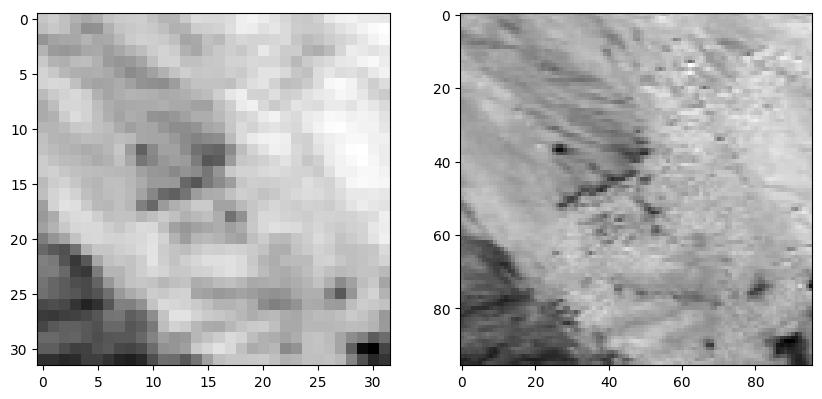

In [12]:
# print first patch and check if LR is in accordance with HR
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(X_train_patches[0,:,:,0], cmap = 'gray')
ax[1].imshow(y_train_patches[0,:,:,0], cmap = 'gray')

In [13]:
# free up memory
del X_train, y_train, y_train_mask

del X_val, y_val, y_val_mask

## 2.2 Clarity patches check

In [14]:
# find patches indices with a lower percentage of clean pixels in train array
patches_to_remove_train = [i for i,m in enumerate(y_train_mask_patches) if np.count_nonzero(m)/(HR_SIZE*HR_SIZE) < CLEAN_PATH_PX]

In [15]:
# find patches indices with a lower percentage of clean pixels in validation array
patches_to_remove_val = [i for i,m in enumerate(y_val_mask_patches) if np.count_nonzero(m)/(HR_SIZE*HR_SIZE) < CLEAN_PATH_PX]

In [16]:
# print number of patches to be removed
print(len(patches_to_remove_train))
print(len(patches_to_remove_val))

3843
242


In [17]:
# remove patches not clean
X_train_patches = np.delete(X_train_patches,patches_to_remove_train,axis=0)
y_train_patches =  np.delete(y_train_patches,patches_to_remove_train,axis=0)
y_train_mask_patches =  np.delete(y_train_mask_patches,patches_to_remove_train,axis=0)

X_val_patches = np.delete(X_val_patches,patches_to_remove_val,axis=0)
y_val_patches =  np.delete(y_val_patches,patches_to_remove_val,axis=0)
y_val_mask_patches =  np.delete(y_val_mask_patches,patches_to_remove_val,axis=0)

In [18]:
transform = RandomRotateFlipTransform()

In [19]:
train_dataset = SuperResolutionDataset(X_train_patches, y_train_patches, y_train_mask_patches, transform = transform)
val_dataset = SuperResolutionDataset(X_val_patches, y_val_patches, y_val_mask_patches)

<a id="network"></a>
# 3.0 Build the network

In [20]:
# Build rams network
rams_network = RAMS(scale=SCALE, in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS, kernel_size=KERNEL_SIZE, r=R, N=N)
rams_network.to(device)


c:\Users\admin\mambaforge\envs\Satellite\lib\site-packages\torch\nn\utils\weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


RAMS(
  (initial_padding): ReflectionPad2d((1, 1, 1, 1, 0, 0))
  (conv_in): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (RFAB_blocks): ModuleList(
    (0-11): 12 x RFAB(
      (conv3d_1): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (conv3d_2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (conv3d_downscale): Conv3d(32, 4, kernel_size=(1, 1, 1), stride=(1, 1, 1))
      (conv3d_upscale): Conv3d(4, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
      (activation): ReLU()
    )
  )
  (conv_out): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (temporal_reduction_blocks): ModuleList(
    (0-2): 3 x Sequential(
      (0): ReflectionPad3d((1, 1, 1, 1, 0, 0))
      (1): RFAB(
        (conv3d_1): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (conv3d_2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  

In [21]:
from torchinfo import summary

# Print architecture structure
summary(rams_network, input_size = (16, 9, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
RAMS                                     [16, 1, 96, 96]           --
├─Sequential: 1-1                        [16, 1, 96, 96]           --
│    └─ReflectionPad2d: 2-1              [16, 9, 34, 34]           --
│    └─RTAB: 2-2                         [16, 9, 34, 34]           --
│    │    └─Conv2d: 3-1                  [16, 9, 34, 34]           747
│    │    └─ReLU: 3-2                    [16, 9, 34, 34]           --
│    │    └─Conv2d: 3-3                  [16, 9, 34, 34]           747
│    │    └─Conv2d: 3-4                  [16, 1, 1, 1]             11
│    │    └─ReLU: 3-5                    [16, 1, 1, 1]             --
│    │    └─Conv2d: 3-6                  [16, 9, 1, 1]             27
│    └─Conv2d: 2-3                       [16, 9, 32, 32]           747
│    └─PixelShuffle: 2-4                 [16, 1, 96, 96]           --
├─ReflectionPad2d: 1-2                   [16, 1, 9, 34, 34]        --
├─Conv3d: 1-

<a id="train"></a>
# 4.0 Train the network

In [22]:
from pytorch_lightning import Trainer

if 1 < 0:
    # Create the LightningModule
    rams_lightning = RAMSLightning(
        model=rams_network, 
        loss_fn=l1_loss, 
        metric_fn=psnr,
        train_dataset=train_dataset, 
        val_dataset=val_dataset, 
        optimizer_class=torch.optim.AdamW, 
        optimizer_params={'lr': 1e-4}
    )

    # Create the Trainer
    trainer = Trainer(
        max_epochs=EPOCHS_N,
        accelerator='gpu',  # if you have GPUs
    )

    # Train the model
    trainer.fit(rams_lightning)

# Test RAMS Deep Neural Network on Proba-V Dataset
![proba_v_dataset](media/RAMS.png "Logo Title Text 1")

The following notebook provides a script to test the pre-trained or re-trained model (if you use the training notebook) using the weights stored in the 'ckpt' folder. The testing is performed with the validation set composed of all the scenes used to evaluate our network and all significant solutions presented in literature at the time of writing. Results can be found in the following table. Your aim is to beat the last row :)

![table_results](media/probav_results_summary.png "Logo Title Text 1")

**NB**: The last chapter of this notebook allows to make predictions with the original test set (ground truth are not public) of the Proba-V ESA challenge. After prediction and zip creation you can submit your file on the official post-mortem challenge, [here](https://kelvins.esa.int/proba-v-super-resolution-post-mortem/home/), and find out your score.

**The notebook is divided in**:
- 1.0 [Dataset Loading](#loading)
- 2.0 [Load the Network](#network)
- 3.0 [Test the network](#test)
    - 3.1 Qualitative results
    - 3.2 Compute RAMS cPSNR
    - 3.3 Compute RAMS+ cPSNR
    - 3.4 Compute RAMS SSIM
    - 3.5 Computer RAMS+ SSIM
- 4.0 [Predict Proba-V Test Set](#proba)
    - 4.1 RAMS prediction
    - 4.2 RAMS+ prediction
    - 4.3 Submission zip creation

In [23]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [32]:
# import utils and basic libraries
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from pytorch.preprocessing import gen_sub, bicubic
from pytorch.loss import l1_loss, psnr, ssim
from pytorch.prediction import ensemble, unensemble, shuffle_last_axis, predict_tensor, predict_tensor_permute, save_predictions, save_predictions_permute
from pytorch.network import RAMS


<a id="loading"></a>
# 1.0 Dataset Loading

In [33]:
# Load validation 
X_val = np.load(os.path.join(PATH_DATASET, f'X_{band}_val.npy'))
y_val = np.load(os.path.join(PATH_DATASET, f'y_{band}_val.npy'))
y_val_mask = np.load(os.path.join(PATH_DATASET, f'y_{band}_val_masks.npy'))

In [34]:
# Load ESA test set (no ground truth)
X_test = np.load(os.path.join(PATH_DATASET, f'X_{band}_test.npy'))

In [35]:
# Print loaded dataset info
print('X_val: ', X_val.shape)
print('y_val: ', y_val.shape)
print('y_val_mask: ', y_val_mask.shape)

print('X_test: ', X_test.shape)

X_val:  (170, 128, 128, 9)
y_val:  (170, 384, 384, 1)
y_val_mask:  (170, 384, 384, 1)
X_test:  (144, 128, 128, 9)


<a id="network"></a>
# 2.0 Load the Network

In [36]:
from pytorch.training import RAMSLightning


In [37]:
# Build rams network
rams_network = RAMS(scale=SCALE, in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS, kernel_size=KERNEL_SIZE, r=R, N=N)
rams_network.to(device)

RAMS(
  (initial_padding): ReflectionPad2d((1, 1, 1, 1, 0, 0))
  (conv_in): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (RFAB_blocks): ModuleList(
    (0-11): 12 x RFAB(
      (conv3d_1): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (conv3d_2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (conv3d_downscale): Conv3d(32, 4, kernel_size=(1, 1, 1), stride=(1, 1, 1))
      (conv3d_upscale): Conv3d(4, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
      (activation): ReLU()
    )
  )
  (conv_out): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (temporal_reduction_blocks): ModuleList(
    (0-2): 3 x Sequential(
      (0): ReflectionPad3d((1, 1, 1, 1, 0, 0))
      (1): RFAB(
        (conv3d_1): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (conv3d_2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  

In [38]:
# load weights from checkpoint_dir
rams_lightning = RAMSLightning.load_from_checkpoint(model = rams_network,
    checkpoint_path='./lightning_logs/version_6/checkpoints/epoch=99-step=31400.ckpt',
    loss_fn=l1_loss, 
    metric_fn=psnr,
    train_dataset=train_dataset, 
    val_dataset=val_dataset, 
    optimizer_class=torch.optim.AdamW, 
    optimizer_params={'lr': 1e-4}
    )

rams_lightning.eval()
rams_lightning.freeze()



<a id="test"></a>
# 3.0 Test the Network

## 3.1 Qualitative results

C:\Users\admin\AppData\Local\Temp\ipykernel_16096\4126232429.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


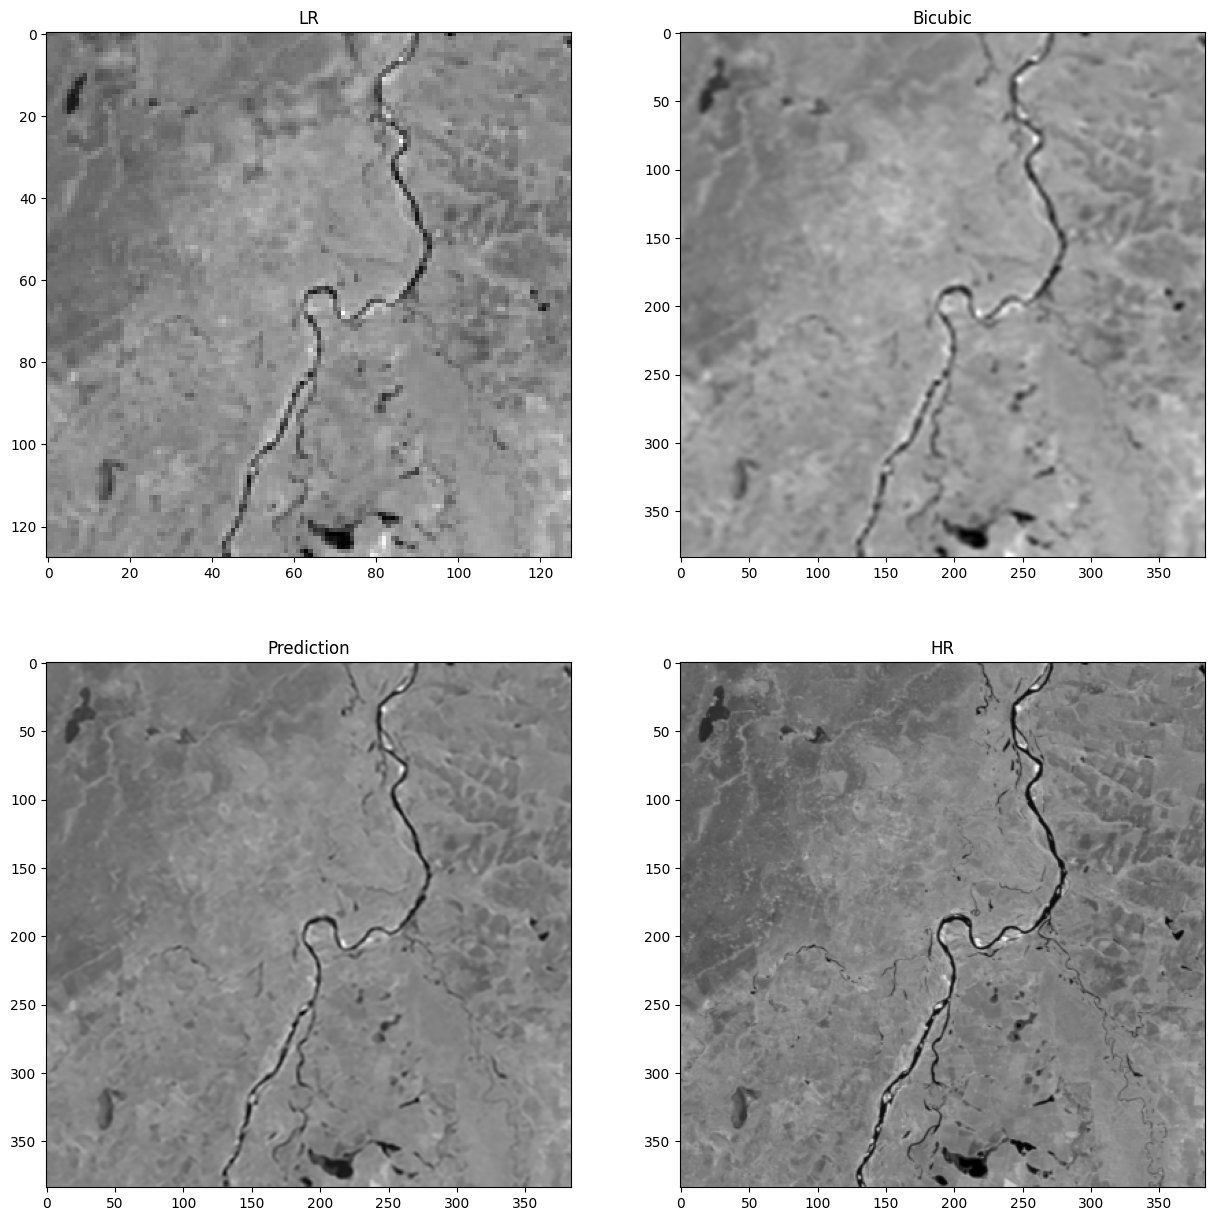

In [39]:
# print example images
index = 15 # choose an image from validation set

x_pred = rams_lightning.predict(X_val, index)

fig, ax = plt.subplots(2,2, figsize=(15,15))
ax[0,0].imshow(X_val[index,:,:,0], cmap = 'gray')
ax[0,0].set_title('LR')
ax[0,1].imshow(bicubic(np.mean(X_val[index:index+1], axis=-1)[...,None])[0,:,:,0], cmap ='gray')
ax[0,1].set_title('Bicubic')
ax[1,0].imshow(x_pred[0,0,:,:], cmap ='gray')
ax[1,0].set_title('Prediction')
ax[1,1].imshow(y_val[index,:,:,0], cmap = 'gray')
ax[1,1].set_title('HR')
fig.show()

## 3.2 Compute RAMS cPSNR

In [40]:
# compute cPSNR with trained network
psnr_scores = []

for index in tqdm(range(X_val.shape[0])):
    x_pred = rams_lightning.predict(X_val, index)
    psnr_scores.append(psnr(y_val[index:index+1,:,:], x_pred, y_val_mask[index:index+1,:,:], HR_SIZE).numpy())

  0%|          | 0/170 [00:00<?, ?it/s]

TypeError: 'int' object is not callable

In [ ]:
# print validation network cPSNR
print(f'PSNR Validation Network: {np.mean(psnr_scores)}')

In [ ]:
# compute cPSNR with bicubic interpolation
psnr_scores_bicubic = []

for index in tqdm(range(X_val.shape[0])):
    x_pred = bicubic(np.mean(X_val[index:index+1], axis=-1)[...,None])
    psnr_scores_bicubic.append(psnr(y_val[index:index+1,:,:], x_pred, y_val_mask[index:index+1,:,:], HR_SIZE).numpy())

In [ ]:
# print validation bicubic cPSNR
print(f'PSNR Validation Bicubic: {np.mean(psnr_scores_bicubic)}')

In [ ]:
# show bicubic vs network comparison
plt.rc('font', size=25)          # controls default text sizes
fig,ax = plt.subplots(figsize=(10,10))

ax.plot(np.arange(30,70,0.5),np.arange(30,70,0.5),'black',linewidth=0.5)
ax.fill_between(np.arange(20,70,0.5), 0, np.arange(20,70,0.5), color = (0/255, 0/255, 230/255, 0.3))
ax.fill_between(np.arange(20,70,0.5), np.arange(20,70,0.5), 70, color = (0/255, 0/255, 230/255, 0.1))

ax.plot(psnr_scores_bicubic, psnr_scores,'x',color='black')

plt.xticks(np.arange(30, 65, step=10))
plt.yticks(np.arange(30, 65, step=10))
plt.ylabel("mPSNR RAMS")
plt.xlabel("mPSNR Bicubic")
ax.axis((25,65,25,65))
ax.set_aspect('equal')
ax.grid(color = 'gray',linestyle='dotted')

## 3.3 Compute RAMS+ cPSNR

In [ ]:
# compute Ensemble PSNR prediction
psnr_scores_plus = []
n_permut = 20 # number of permutations

for index in tqdm(range(X_val.shape[0])):
    x_pred = predict_tensor_permute(rams_network, X_val[index],n_ens=n_permut)
    psnr_scores_plus.append(psnr(y_val[index:index+1,:,:], x_pred, y_val_mask[index:index+1,:,:], HR_SIZE).numpy())

In [ ]:
# print validation Ensamble cPSNR
print(f'PSNR Validation Ensamble: {np.mean(psnr_scores_plus)}')